# Choose the CPU cores number you want to use

In [1]:
import ray
ray.init(num_cpus=50, num_gpus=1)

2020-11-15 17:21:52,352	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8267


{'node_ip_address': '128.10.130.25',
 'raylet_ip_address': '128.10.130.25',
 'redis_address': '128.10.130.25:21301',
 'object_store_address': '/tmp/ray/session_2020-11-15_17-21-50_663949_50233/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-11-15_17-21-50_663949_50233/sockets/raylet',
 'webui_url': '127.0.0.1:8267',
 'session_dir': '/tmp/ray/session_2020-11-15_17-21-50_663949_50233',
 'metrics_export_port': 57530}

# Prepare

In [2]:
import CoRec
import gym
import numpy as np

import stable_baselines
from stable_baselines import TRPO
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common import make_vec_env
from stable_baselines.common.vec_env import DummyVecEnv, SubprocVecEnv

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from ray import tune

W1115 17:21:58.626657 139780108629824 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# Reward is simply set as the number of safe steps

In [3]:
class RewardWrapper(gym.RewardWrapper):
    def __init__(self, env):
        super().__init__(env)

    def reward(self, r):
        if r <= -1:
            r = 0
        else:
            r += 0.1

        return r

# Hyper-parameters Range

In [4]:
def trpo_hyper(**kwargs): return kwargs

config = trpo_hyper(
    gamma=tune.uniform(0.95, 1), 
    timesteps_per_batch=tune.choice([256, 512, 1024, 2048, 4096]),
    max_kl=tune.loguniform(1e-3, 0.1), 
    cg_iters=tune.randint(5, 20), 
    lam=tune.uniform(0.95, 0.999), 
    entcoeff=0.05, 
    cg_damping=tune.loguniform(1e-3, 0.1), 
    vf_stepsize=tune.uniform(0.0001, 0.001), 
    vf_iters=tune.randint(3, 10), 
    seed=1
)
    
config

{'gamma': <ray.tune.sample.Float at 0x7f126ddc60f0>,
 'timesteps_per_batch': <ray.tune.sample.Categorical at 0x7f1256362d30>,
 'max_kl': <ray.tune.sample.Float at 0x7f1256362da0>,
 'cg_iters': <ray.tune.sample.Integer at 0x7f1256362e10>,
 'lam': <ray.tune.sample.Float at 0x7f1256362e80>,
 'entcoeff': 0.05,
 'cg_damping': <ray.tune.sample.Float at 0x7f1256362ef0>,
 'vf_stepsize': <ray.tune.sample.Float at 0x7f1256362f60>,
 'vf_iters': <ray.tune.sample.Integer at 0x7f1256362fd0>,
 'seed': 1}

# Train
Error can happen because numerical instability in the model itself.

In [5]:
def env_func(): return RewardWrapper(gym.make("F16GCAS-v3"))
env = env_func() #make_vec_env(env_func, n_envs=4)

In [6]:
class ReportCallback(stable_baselines.common.callbacks.BaseCallback):
    def __init__(self, verbose=0):
        super(ReportCallback, self).__init__(verbose)
        
    def _on_rollout_end(self) -> None:
#         ep_rewards = self.model.logger.getkvs() # [ep_info["r"] for ep_info in self.model.ep_info_buf]
        ep_rew_mean = self.logger.name2val["EpRewMean"]
        tune.report(ep_rew = ep_rew_mean)
    
    def _on_step(self) -> bool:
        return True
    
def F16_trpo(config):
    callback = ReportCallback()
    model = TRPO(MlpPolicy, env, verbose=0, **config)
    model.learn(total_timesteps=250000//4, callback=callback)
    model.save("trpo_f16")

# conc_conf = {}
# for k, v in config.items():
#     try:
#         conc = v.sample()
#         conc_conf[k] = conc
#     except:
#         conc_conf[k] = v
# conc_conf
# F16_trpo(conc_conf)
analysis = tune.run(F16_trpo, config=config, num_samples=50, verbose=1, metric="ep_rew", mode="max", raise_on_failed_trial=False)

Trial name,status,loc,cg_damping,cg_iters,gamma,lam,max_kl,timesteps_per_batch,vf_iters,vf_stepsize,iter,total time (s),ep_rew
F16_trpo_fa3ff_00000,TERMINATED,,0.00246565,7,0.951113,0.955206,0.0233555,1024,5,0.000956465,62,160.811,86.8227
F16_trpo_fa3ff_00001,TERMINATED,,0.00477588,15,0.982907,0.963286,0.0765045,2048,4,0.000838103,31,155.143,70.3604
F16_trpo_fa3ff_00002,TERMINATED,,0.00416003,9,0.966266,0.966835,0.0161784,512,9,0.000185829,123,165.466,93.4686
F16_trpo_fa3ff_00003,TERMINATED,,0.0715967,10,0.970289,0.990997,0.00691338,256,7,0.000676858,245,166.635,79.8
F16_trpo_fa3ff_00004,TERMINATED,,0.00191586,17,0.982943,0.960586,0.00339332,2048,3,0.000623161,31,155.161,64.4995
F16_trpo_fa3ff_00005,TERMINATED,,0.042859,13,0.991341,0.994183,0.00162043,512,7,0.000345429,123,164.058,67.1565
F16_trpo_fa3ff_00006,TERMINATED,,0.0347883,5,0.982328,0.956011,0.0403755,256,5,0.000568371,245,161.579,123.29
F16_trpo_fa3ff_00007,TERMINATED,,0.0181032,6,0.953464,0.956344,0.00102953,512,4,0.000529283,123,158.804,65.7218
F16_trpo_fa3ff_00008,TERMINATED,,0.012801,13,0.95587,0.982211,0.00152228,2048,3,0.000217736,31,153.632,64.0462
F16_trpo_fa3ff_00009,TERMINATED,,0.0432309,8,0.971716,0.976549,0.00104211,512,6,0.000152978,123,161.857,65.7008


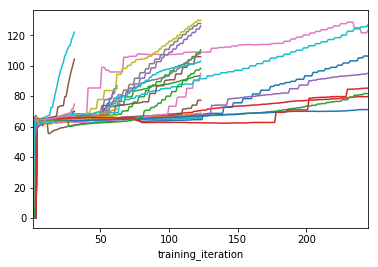

In [7]:
ax = None
dfs = analysis.trial_dataframes
for d in dfs.values():
    ax = d.plot("training_iteration", "ep_rew", ax=ax, legend=False)

In [8]:
import seaborn as sns
import pandas as pd

new_frame = []
for d in dfs.values():
    new_frame.append(pd.concat([d["training_iteration"], d["ep_rew"]], axis=1))

new_frame = pd.concat(new_frame, axis=0)
new_frame.insert(2, "algo", "trpo")
new_frame.to_csv("rl_train_res/trpo.csv")
new_frame.head()

,training_iteration,ep_rew,algo
0,1,0.000000,trpo
1,2,63.197687,trpo
2,3,65.044622,trpo
3,4,65.010277,trpo
4,5,64.924514,trpo


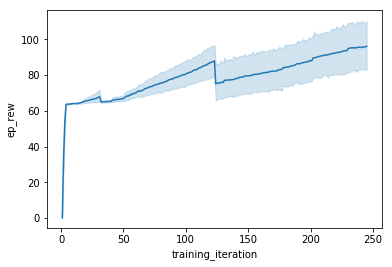

In [9]:
sns.lineplot(data=new_frame, x="training_iteration", y="ep_rew")

In [10]:
analysis.get_best_config(metric="ep_rew", mode="max")

{'gamma': 0.9683320830748454,
 'timesteps_per_batch': 512,
 'max_kl': 0.03562523294461153,
 'cg_iters': 8,
 'lam': 0.9983185940743623,
 'entcoeff': 0.05,
 'cg_damping': 0.0465065914710232,
 'vf_stepsize': 0.0005801165847858822,
 'vf_iters': 7,
 'seed': 1}

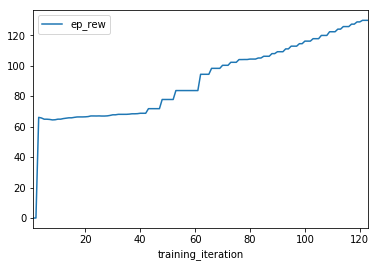

In [11]:
analysis.best_dataframe.plot("training_iteration", "ep_rew")